# rf_notebook
- Implementing random forest to investigate the dependencies of galaxy spin [$\lambda_R$](https://arxiv.org/abs/astro-ph/0703531) outside of stellar mass. 

## status
- implemented rf (also tuned rf without morphology)
- once you have combined mass, cw + local environment, morphology *and* inclination you get a reasonable prediction for $\lambda_R$
- sersic index appears to be more informative than everything else, however, other galaxyzoo flags do add information (although debiased continuous vote fractions rather than one-hot encoding)
- cosmic web is mildly important (similar level to halo mass)
- group membership is unimportant

## to do 
- tidy into scripts 
- perform tuning on rfs
- compare to best rf based on only two params ($n_{sersic}$ and $M_{stel}$)
- define performance metric (maybe convert MADE into percentage error difference)

In [1]:
# general 
import numpy as np
import pandas as pd
from scipy import stats

# plotting
import matplotlib.pyplot as plt
import seaborn as sns
import harry_plotter as hp

# catalog class and associated libs.
import catalog
import catalog_init 
import catalog_process
import catalog_plot
import copy

# sklearn
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import export_graphviz
import pydot

# plotting defaults.
from matplotlib.pyplot import rcParams
catalog_plot.default(rcParams)

### Creating catalog object 
- Matches and combines catalogues based on defined choice
- Combines cosmic web, MaNGA and group catalogues here.
- pd.DataFrame is a property of the class which we use as input for the random forest here.

In [2]:
basepath = '../../catalogues/'
outpath = './'

# initiating catalog class object for all galaxies.
galaxies = catalog.Catalog(basepath, version='mpl9', match_to_lim=True)

# matching to cosmic web catalogue
galaxies.match_to_cw(basepath, version='mpl9', sigma=3)

In [3]:
galaxies.df.head(5)

CATALOG_RA  CATALOG_DEC     NSA_Z MANGAID_x   ID   GalID          px  \
0  159.827061     0.839858  0.065915    1-3019  147   15113 -275.382448   
1  160.143696     0.817429  0.065825    1-3050  148   12121 -273.812275   
2  160.760696     0.905083  0.125503    1-3087  150   58783 -512.637809   
3  160.966486     1.061669  0.115905    1-3343  165   73456 -481.467757   
4  203.752677    -0.447620  0.021990   1-10808  570  144684  -92.891861   

           py        pz  log_dskel  ...  vel_sigma_Re  e_vel_sigma_Re  \
0  101.173331  4.300716   0.043255  ...      0.122828        0.097637   
1   98.882583  4.153580  -0.878621  ...      0.503052        0.088168   
2  178.913657  8.577672  -0.013595  ...      0.086852        0.124708   
3  166.097729  9.438687  -0.460942  ...      0.359424        0.084244   
4  -40.878621 -0.792863  -0.194282  ...      0.326402        0.268645   

   Lambda_Re  e_Lambda_Re  plate_y  ifudsgn_y  nsa_elpetro_mass_logscale  \
0   0.097408     0.154860    10837       6102                  10.922176   
1   0.642676     0.225280    10837       3701                  10.888331   
2   0.085910     0.246711    10837       3703                  11.068974   
3   0.275265     0.129037    10837       3704                  11.179978   
4   0.565687     0.931179    11024       3703                   8.687317   

   log_dskel_norm  log_dwall_norm  log_dnode_norm  
0       -0.728546       -0.756051        0.037368  
1       -1.649340       -0.711134        1.572121  
2       -0.986655       -1.382987       -1.070399  
3       -1.386935       -1.763926       -0.896978  
4       -0.766828       -0.645687       -0.128733  

[5 rows x 421 columns]

### Selecting input features and labels
- Features : stellar mass ($M_{stel}$), halo mass ($M_{halo}$), group membership (central/satellite), distance to nodes ($D_{node}$), distance to filaments ($D_{skel}$). 
- Labels : spin ($\lambda_R$)

In [4]:
# creating group membership binary (0 - central, 1 - satellite) flag.
group_flag = np.zeros(galaxies.df.shape[0])

group_flag[galaxies.df.galaxyID.values == galaxies.df.cenID.values] = 0
group_flag[galaxies.df.galaxyID.values != galaxies.df.cenID.values] = 1

# adding flag to df
galaxies.df['group_flag'] = group_flag.astype(int)

In [17]:
# computing Ttype property (typically only relevant for LTGs but we shall see)


Ttype = (4.63 + 4.17 * galaxies.df.t05_bulge_prominence_a10_no_bulge_debiased 
         - 2.27 * galaxies.df.t05_bulge_prominence_a12_obvious_debiased - 8.38 
         * galaxies.df.t05_bulge_prominence_a13_dominant_debiased )

galaxies.df['ttype'] = Ttype


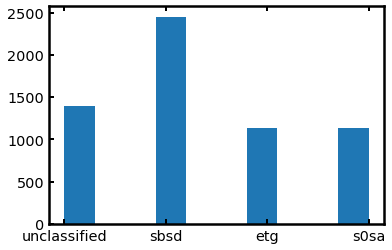

In [58]:
morph = np.full(galaxies.df.shape[0], 'unclassified')
morph[catalog_init.select_morphology(galaxies.df, morphology='etg', vote_frac=0.7).index] = 'etg'
morph[catalog_init.select_morphology(galaxies.df, morphology='s0sa', vote_frac=0.7).index] = 's0sa'
morph[catalog_init.select_morphology(galaxies.df, morphology='sbsd', vote_frac=0.7).index] = 'sbsd'

plt.hist(morph);

In [106]:
labels = galaxies.df.Lambda_Re.values
features = galaxies.df[['nsa_elpetro_mass_logscale', 
                        't01_smooth_or_features_a01_smooth_debiased',
                        'nsa_elpetro_ba',
                        'nsa_sersic_n',
                        'ttype',
                        'log_halo_mass', 
                        'group_flag', 
                        'log_dnode_norm', 
                        'log_dskel_norm',
                        'log_dwall_norm']]

features['morph'] = morph
features = pd.get_dummies(features)
features.head(5)

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]


nsa_elpetro_mass_logscale  t01_smooth_or_features_a01_smooth_debiased  \
0                  10.922176                                    0.228571   
1                  10.888331                                    0.000000   
2                  11.068974                                    0.783146   
3                  11.179978                                    0.160844   
4                   8.687317                                    0.619992   

   nsa_elpetro_ba  nsa_sersic_n     ttype  log_halo_mass  group_flag  \
0        0.900672      4.787008  0.442053         13.628           0   
1        0.671205      1.614743  3.205008         13.628           1   
2        0.785825      6.000000  2.360000         13.856           0   
3        0.688610      6.000000 -1.730667         13.570           0   
4        0.669178      0.922016  8.256406         11.260           0   

   log_dnode_norm  log_dskel_norm  log_dwall_norm  morph_etg  morph_s0sa  \
0        0.037368       -0.728546       -0.756051          0           0   
1        1.572121       -1.649340       -0.711134          0           0   
2       -1.070399       -0.986655       -1.382987          1           0   
3       -0.896978       -1.386935       -1.763926          0           1   
4       -0.128733       -0.766828       -0.645687          0           0   

   morph_sbsd  morph_unclassified  
0           0                   1  
1           1                   0  
2           0                   0  
3           0                   0  
4           0                   1

### Using sklearn to divide into train and testing samples (to sanity check fit)

In [108]:
X_train, X_test, y_train, y_test = train_test_split(np.array(features), labels, test_size = 0.2, 
                                                    shuffle=True)
y_train.shape, y_test.shape

((4893,), (1224,))

### Instantiate basic random forest regressor and training
- Going for default settings with 1000 trees to test baseline performance

In [109]:
# selecting there to be 1000 trees in the forest.
rf = RandomForestRegressor(n_estimators = 1000)

# Train the model on training data
rf.fit(X_train, y_train)

RandomForestRegressor(n_estimators=1000)

### Testing trained model using test data

In [110]:
# Use the forest's predict method on the test data
predictions = rf.predict(X_test)

# Calculate the absolute errors
errors = np.abs(predictions - y_test)

# Print out the mean absolute error (mae)
print('Mean Absolute Error:', round(np.mean(errors), 2))

Mean Absolute Error: 0.12


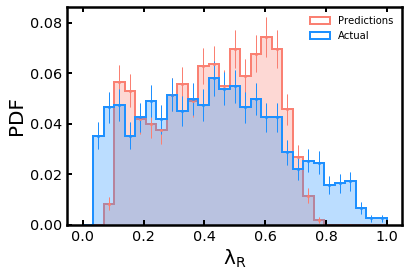

In [111]:
# plotting predicted and actual lambda_R distributions
bins = np.linspace(0, 1, 30)

fig, ax = plt.subplots()
hp.normalised_histogram(predictions, ax=ax, color='salmon', bins=bins, label='Predictions', style='shadedstep')
hp.normalised_histogram(y_test, ax=ax, color='dodgerblue', bins=bins, label='Actual', style='shadedstep')
ax.legend(frameon=False)
ax.set_xlabel('$\mathrm{\lambda_R}$', fontsize=20)
ax.set_ylabel('PDF', fontsize=20)
plt.show()

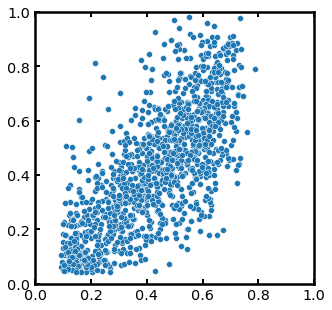

In [112]:
fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot()
sns.scatterplot(x=predictions, y=y_test, ax=ax)
ax.set_xlim([0, 1])
ax.set_ylim([0, 1])

plt.show()

nsa_elpetro_mass_logscale: 0.07322792004124808
t01_smooth_or_features_a01_smooth_debiased: 0.09875422010323638
nsa_elpetro_ba: 0.10571466390403124
nsa_sersic_n: 0.4802077945687982
ttype: 0.06237369707527416
log_halo_mass: 0.049634581061634604
group_flag: 0.003919282235816723
log_dnode_norm: 0.03907549929293052
log_dskel_norm: 0.03641004048112306
log_dwall_norm: 0.04161695387559418
morph_etg: 0.0006091328196309707
morph_s0sa: 0.0009509067179064309
morph_sbsd: 0.004394540757371324
morph_unclassified: 0.0031107670654042263


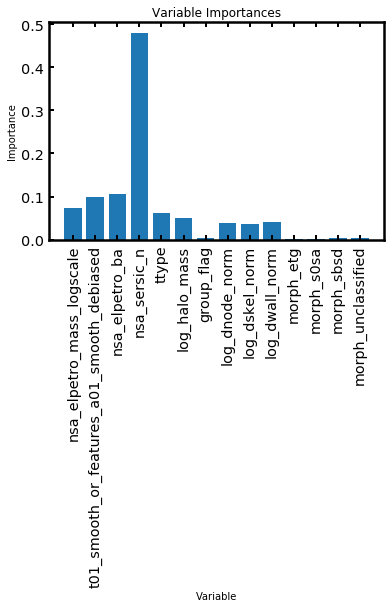

In [113]:
# Get numerical feature importances
importances = list(rf.feature_importances_)

for feat, imp in zip(features.columns, importances):
    print(feat + ': {}'.format(imp))
    
x_values = list(range(len(importances)))

# Make a bar chart
plt.bar(x_values, importances, orientation = 'vertical')

# Tick labels for x axis
plt.xticks(x_values, features.columns, rotation=90)

# Axis labels and title
plt.ylabel('Importance'); plt.xlabel('Variable'); plt.title('Variable Importances');

### Tuning hyperparameters of the random forest to improve performance
- By default the features here may not be completely informative of $\lambda_R$
- A crucial _missing_ feature here is visual morphology (we can one-hot encode classifications *or* use a continuous variable (vote fraction / sersic index))
- However, performing some hyperparameter tuning to see if we can create a better model

In [58]:
# Number of trees in random forest
n_estimators = [500, 1000, 1500, 2000]

# Number of features to consider at every split
max_features = ['auto', 'sqrt']

# Maximum number of levels in tree
max_depth = [10, 50, 110]
max_depth.append(None)

# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]

# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]

# Method of selecting samples for training each tree
bootstrap = [True, False]

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

random_grid

{'n_estimators': [500, 1000, 1500, 2000],
 'max_features': ['auto', 'sqrt'],
 'max_depth': [10, 50, 110, None],
 'min_samples_split': [2, 5, 10],
 'min_samples_leaf': [1, 2, 4],
 'bootstrap': [True, False]}

In [63]:
# Use the random grid to search for best hyperparameters

# First create the base model to tune
rf = RandomForestRegressor()

# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, 
                               param_distributions = random_grid, 
                               n_iter = 100, 
                               cv = 3, 
                               verbose=2,
                               n_jobs=1)

# Fit the random search model
rf_random.fit(X_train, y_train)


Fitting 3 folds for each of 100 candidates, totalling 300 fits
[CV] n_estimators=2000, min_samples_split=10, min_samples_leaf=1, max_features=sqrt, max_depth=50, bootstrap=False 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  n_estimators=2000, min_samples_split=10, min_samples_leaf=1, max_features=sqrt, max_depth=50, bootstrap=False, total=  11.2s
[CV] n_estimators=2000, min_samples_split=10, min_samples_leaf=1, max_features=sqrt, max_depth=50, bootstrap=False 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   11.2s remaining:    0.0s


[CV]  n_estimators=2000, min_samples_split=10, min_samples_leaf=1, max_features=sqrt, max_depth=50, bootstrap=False, total=  10.0s
[CV] n_estimators=2000, min_samples_split=10, min_samples_leaf=1, max_features=sqrt, max_depth=50, bootstrap=False 
[CV]  n_estimators=2000, min_samples_split=10, min_samples_leaf=1, max_features=sqrt, max_depth=50, bootstrap=False, total=  10.2s
[CV] n_estimators=1000, min_samples_split=2, min_samples_leaf=2, max_features=sqrt, max_depth=110, bootstrap=False 
[CV]  n_estimators=1000, min_samples_split=2, min_samples_leaf=2, max_features=sqrt, max_depth=110, bootstrap=False, total=   5.9s
[CV] n_estimators=1000, min_samples_split=2, min_samples_leaf=2, max_features=sqrt, max_depth=110, bootstrap=False 
[CV]  n_estimators=1000, min_samples_split=2, min_samples_leaf=2, max_features=sqrt, max_depth=110, bootstrap=False, total=   5.2s
[CV] n_estimators=1000, min_samples_split=2, min_samples_leaf=2, max_features=sqrt, max_depth=110, bootstrap=False 
[CV]  n_esti

[CV]  n_estimators=1500, min_samples_split=10, min_samples_leaf=4, max_features=auto, max_depth=None, bootstrap=True, total=   9.9s
[CV] n_estimators=1000, min_samples_split=2, min_samples_leaf=1, max_features=sqrt, max_depth=110, bootstrap=False 
[CV]  n_estimators=1000, min_samples_split=2, min_samples_leaf=1, max_features=sqrt, max_depth=110, bootstrap=False, total=   7.2s
[CV] n_estimators=1000, min_samples_split=2, min_samples_leaf=1, max_features=sqrt, max_depth=110, bootstrap=False 
[CV]  n_estimators=1000, min_samples_split=2, min_samples_leaf=1, max_features=sqrt, max_depth=110, bootstrap=False, total=   7.3s
[CV] n_estimators=1000, min_samples_split=2, min_samples_leaf=1, max_features=sqrt, max_depth=110, bootstrap=False 
[CV]  n_estimators=1000, min_samples_split=2, min_samples_leaf=1, max_features=sqrt, max_depth=110, bootstrap=False, total=   7.4s
[CV] n_estimators=500, min_samples_split=10, min_samples_leaf=2, max_features=sqrt, max_depth=50, bootstrap=True 
[CV]  n_estim

[CV]  n_estimators=1500, min_samples_split=10, min_samples_leaf=1, max_features=sqrt, max_depth=50, bootstrap=True, total=   5.5s
[CV] n_estimators=1500, min_samples_split=10, min_samples_leaf=1, max_features=sqrt, max_depth=50, bootstrap=True 
[CV]  n_estimators=1500, min_samples_split=10, min_samples_leaf=1, max_features=sqrt, max_depth=50, bootstrap=True, total=   5.3s
[CV] n_estimators=1500, min_samples_split=10, min_samples_leaf=1, max_features=sqrt, max_depth=50, bootstrap=True 
[CV]  n_estimators=1500, min_samples_split=10, min_samples_leaf=1, max_features=sqrt, max_depth=50, bootstrap=True, total=   5.3s
[CV] n_estimators=2000, min_samples_split=10, min_samples_leaf=1, max_features=auto, max_depth=10, bootstrap=True 
[CV]  n_estimators=2000, min_samples_split=10, min_samples_leaf=1, max_features=auto, max_depth=10, bootstrap=True, total=  10.8s
[CV] n_estimators=2000, min_samples_split=10, min_samples_leaf=1, max_features=auto, max_depth=10, bootstrap=True 
[CV]  n_estimators=2

[CV]  n_estimators=2000, min_samples_split=2, min_samples_leaf=1, max_features=sqrt, max_depth=None, bootstrap=False, total=  12.8s
[CV] n_estimators=2000, min_samples_split=2, min_samples_leaf=1, max_features=sqrt, max_depth=None, bootstrap=False 
[CV]  n_estimators=2000, min_samples_split=2, min_samples_leaf=1, max_features=sqrt, max_depth=None, bootstrap=False, total=  12.7s
[CV] n_estimators=1000, min_samples_split=10, min_samples_leaf=2, max_features=sqrt, max_depth=110, bootstrap=False 
[CV]  n_estimators=1000, min_samples_split=10, min_samples_leaf=2, max_features=sqrt, max_depth=110, bootstrap=False, total=   5.3s
[CV] n_estimators=1000, min_samples_split=10, min_samples_leaf=2, max_features=sqrt, max_depth=110, bootstrap=False 
[CV]  n_estimators=1000, min_samples_split=10, min_samples_leaf=2, max_features=sqrt, max_depth=110, bootstrap=False, total=   4.9s
[CV] n_estimators=1000, min_samples_split=10, min_samples_leaf=2, max_features=sqrt, max_depth=110, bootstrap=False 
[CV]

[CV]  n_estimators=1000, min_samples_split=5, min_samples_leaf=2, max_features=sqrt, max_depth=None, bootstrap=True, total=   3.7s
[CV] n_estimators=500, min_samples_split=2, min_samples_leaf=2, max_features=sqrt, max_depth=50, bootstrap=False 
[CV]  n_estimators=500, min_samples_split=2, min_samples_leaf=2, max_features=sqrt, max_depth=50, bootstrap=False, total=   2.9s
[CV] n_estimators=500, min_samples_split=2, min_samples_leaf=2, max_features=sqrt, max_depth=50, bootstrap=False 
[CV]  n_estimators=500, min_samples_split=2, min_samples_leaf=2, max_features=sqrt, max_depth=50, bootstrap=False, total=   2.7s
[CV] n_estimators=500, min_samples_split=2, min_samples_leaf=2, max_features=sqrt, max_depth=50, bootstrap=False 
[CV]  n_estimators=500, min_samples_split=2, min_samples_leaf=2, max_features=sqrt, max_depth=50, bootstrap=False, total=   2.7s
[CV] n_estimators=500, min_samples_split=2, min_samples_leaf=4, max_features=sqrt, max_depth=None, bootstrap=False 
[CV]  n_estimators=500, 

[CV]  n_estimators=2000, min_samples_split=2, min_samples_leaf=2, max_features=sqrt, max_depth=10, bootstrap=True, total=   6.3s
[CV] n_estimators=2000, min_samples_split=2, min_samples_leaf=2, max_features=sqrt, max_depth=10, bootstrap=True 
[CV]  n_estimators=2000, min_samples_split=2, min_samples_leaf=2, max_features=sqrt, max_depth=10, bootstrap=True, total=   6.5s
[CV] n_estimators=2000, min_samples_split=2, min_samples_leaf=2, max_features=sqrt, max_depth=10, bootstrap=True 
[CV]  n_estimators=2000, min_samples_split=2, min_samples_leaf=2, max_features=sqrt, max_depth=10, bootstrap=True, total=   6.4s
[CV] n_estimators=1500, min_samples_split=10, min_samples_leaf=4, max_features=sqrt, max_depth=50, bootstrap=False 
[CV]  n_estimators=1500, min_samples_split=10, min_samples_leaf=4, max_features=sqrt, max_depth=50, bootstrap=False, total=   8.2s
[CV] n_estimators=1500, min_samples_split=10, min_samples_leaf=4, max_features=sqrt, max_depth=50, bootstrap=False 
[CV]  n_estimators=150

[CV]  n_estimators=2000, min_samples_split=10, min_samples_leaf=4, max_features=sqrt, max_depth=10, bootstrap=False, total=   7.9s
[CV] n_estimators=2000, min_samples_split=10, min_samples_leaf=4, max_features=sqrt, max_depth=10, bootstrap=False 
[CV]  n_estimators=2000, min_samples_split=10, min_samples_leaf=4, max_features=sqrt, max_depth=10, bootstrap=False, total=   8.2s
[CV] n_estimators=1500, min_samples_split=2, min_samples_leaf=2, max_features=sqrt, max_depth=50, bootstrap=True 
[CV]  n_estimators=1500, min_samples_split=2, min_samples_leaf=2, max_features=sqrt, max_depth=50, bootstrap=True, total=   6.2s
[CV] n_estimators=1500, min_samples_split=2, min_samples_leaf=2, max_features=sqrt, max_depth=50, bootstrap=True 
[CV]  n_estimators=1500, min_samples_split=2, min_samples_leaf=2, max_features=sqrt, max_depth=50, bootstrap=True, total=   5.8s
[CV] n_estimators=1500, min_samples_split=2, min_samples_leaf=2, max_features=sqrt, max_depth=50, bootstrap=True 
[CV]  n_estimators=150

[CV]  n_estimators=500, min_samples_split=10, min_samples_leaf=2, max_features=sqrt, max_depth=None, bootstrap=False, total=   2.4s
[CV] n_estimators=2000, min_samples_split=10, min_samples_leaf=2, max_features=sqrt, max_depth=10, bootstrap=False 
[CV]  n_estimators=2000, min_samples_split=10, min_samples_leaf=2, max_features=sqrt, max_depth=10, bootstrap=False, total=   7.5s
[CV] n_estimators=2000, min_samples_split=10, min_samples_leaf=2, max_features=sqrt, max_depth=10, bootstrap=False 
[CV]  n_estimators=2000, min_samples_split=10, min_samples_leaf=2, max_features=sqrt, max_depth=10, bootstrap=False, total=   8.3s
[CV] n_estimators=2000, min_samples_split=10, min_samples_leaf=2, max_features=sqrt, max_depth=10, bootstrap=False 
[CV]  n_estimators=2000, min_samples_split=10, min_samples_leaf=2, max_features=sqrt, max_depth=10, bootstrap=False, total=   7.9s
[CV] n_estimators=500, min_samples_split=10, min_samples_leaf=2, max_features=auto, max_depth=110, bootstrap=True 
[CV]  n_esti

[CV]  n_estimators=1500, min_samples_split=2, min_samples_leaf=1, max_features=sqrt, max_depth=10, bootstrap=True, total=   4.7s
[CV] n_estimators=1500, min_samples_split=2, min_samples_leaf=1, max_features=sqrt, max_depth=10, bootstrap=True 
[CV]  n_estimators=1500, min_samples_split=2, min_samples_leaf=1, max_features=sqrt, max_depth=10, bootstrap=True, total=   4.6s
[CV] n_estimators=1500, min_samples_split=2, min_samples_leaf=1, max_features=sqrt, max_depth=10, bootstrap=True 
[CV]  n_estimators=1500, min_samples_split=2, min_samples_leaf=1, max_features=sqrt, max_depth=10, bootstrap=True, total=   4.5s
[CV] n_estimators=1000, min_samples_split=2, min_samples_leaf=2, max_features=sqrt, max_depth=None, bootstrap=True 
[CV]  n_estimators=1000, min_samples_split=2, min_samples_leaf=2, max_features=sqrt, max_depth=None, bootstrap=True, total=   4.0s
[CV] n_estimators=1000, min_samples_split=2, min_samples_leaf=2, max_features=sqrt, max_depth=None, bootstrap=True 
[CV]  n_estimators=100

[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed: 35.9min finished


RandomizedSearchCV(cv=3, estimator=RandomForestRegressor(), n_iter=100,
                   n_jobs=1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 50, 110, None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [500, 1000, 1500,
                                                         2000]},
                   verbose=2)

In [64]:
rf_random.best_params_

{'n_estimators': 500,
 'min_samples_split': 10,
 'min_samples_leaf': 1,
 'max_features': 'sqrt',
 'max_depth': 10,
 'bootstrap': True}

### Using best forest estimator to make new set of predictions

In [66]:
best_random = rf_random.best_estimator_

# Use the forest's predict method on the test data
best_predictions = best_random.predict(X_test)

# Calculate the absolute errors
best_errors = np.abs(best_predictions - y_test)

# Print out the mean absolute error (mae)
print('Mean Absolute Error:', round(np.mean(best_errors), 2))

Mean Absolute Error: 0.17


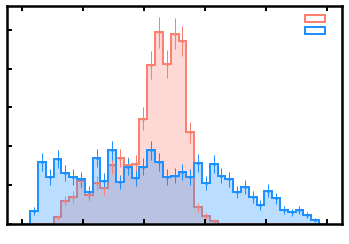

In [70]:
# plotting predicted and actual lambda_R distributions
bins = np.linspace(0, 1, 40)

fig, ax = plt.subplots()
hp.normalised_histogram(best_predictions, ax=ax, color='salmon', bins=bins, label='Best Predictions', style='shadedstep')
hp.normalised_histogram(y_test, ax=ax, color='dodgerblue', bins=bins, label='Actual', style='shadedstep')
ax.legend(frameon=False)
ax.set_xlabel('$\mathrm{\lambda_R}$', fontsize=20)
ax.set_ylabel('PDF', fontsize=20)
plt.show()

### There is no significant difference between the gridsearch model and the original with default parameters
- This suggests that the features are _fairly_ uninformative of $\lambda_R$ and we should consider including morpholgy
- Secondly lets create a grid (with pearsonr) to investigate individual correlations of features with the labels
- Finally we _could_ consider further tuning of the hyperparameters with a larger grid search

### Importance ranking of variables

In [81]:
# Get numerical feature importances
importances = list(best_random.feature_importances_)

for feat, imp in zip(features.columns, importances):
    print(feat + ': {}'.format(imp))

nsa_elpetro_mass_logscale: 0.44064817371983733
log_halo_mass: 0.23838309793693485
group_flag: 0.033714187107697316
log_dnode_norm: 0.14071048054346375
log_dskel_norm: 0.14654406069206663


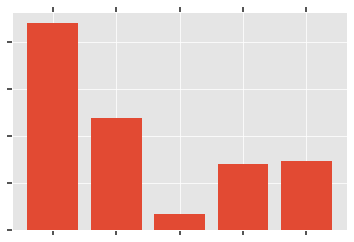

In [85]:
plt.style.use('ggplot')
x_values = list(range(len(importances)))

# Make a bar chart
plt.bar(x_values, importances, orientation = 'vertical')

# Tick labels for x axis
plt.xticks(x_values, features.columns, rotation='vertical')

# Axis labels and title
plt.ylabel('Importance'); plt.xlabel('Variable'); plt.title('Variable Importances');